In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap.
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1

We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of Algorithm 1: with $b = -\nabla V$


In [3]:
potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 426483.65625
Test loss is 484870.375
s:  0.1
Train loss: 105848.4453125
Test loss is 123657.2265625
s:  0.5
Train loss: 11086.189453125
Test loss is 10827.265625


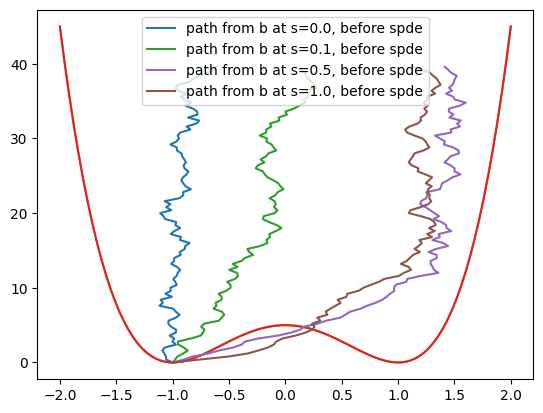

In [ ]:
key = jax.random.key(0)
schedule = [0.1, 0.5, 1.0]

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        refine=False
    )

old s 0.0
Train loss: 426483.65625
Test loss is 484870.375
old s 0.1
Train loss: 68838.859375
Test loss is 75415.859375
old s 0.5
Train loss: 4446.94873046875
Test loss is 3912.728271484375


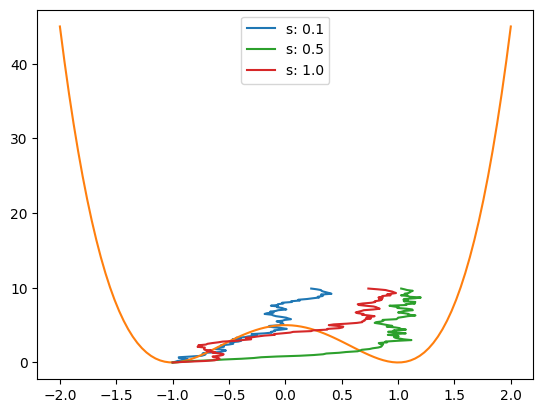

In [4]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.2, 0.4, 0.6, 0.8, 1.0]
schedule = [0.1,0.5,1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



from path_sampling import dfdt, div_f, update, update_non_amortized


def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds, A = update(
        V=make_double_well_potential(v=5.0),
        uref=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        # I=I_UREF_TPS,
        prior='sde_prior',
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)